University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2022  
Luigi Acerbi

# Week 3 exercises

**General hints**:  
- **In order to estimate the accuracy of your answer**, it is recommended to run the sampler a few times and compute the standard deviation of the values you obtain. If the standard deviation of the values you obtain is smaller than the tolerance, the average of the values you obtain should be within the tolerance, assuming everything was done correctly.
- Monte Carlo error scales as $1/\sqrt{n}$ with the number of iterations $n$, i.e. you need to increase the number of iterations by a factor of 4 to cut the error in half.

## 1. Sampling a 1D distribution (4 points)

Write a Metropolis-Hastings sampler to sample from the (unnormalised) distribution
$$ P^*(\theta) = \cos^2(\theta) \exp(-|\theta|^3) $$
using a normal distribution with standard deviation $\sigma$ as the proposal
$q(\theta' ; \theta) = \mathcal{N}(\theta';\; \theta, \sigma^2)$.

1. Initialising the sampler at $\theta = 0$, draw 10000 samples with $\sigma=0.5$. Report the acceptance rate of the samples in Moodle.
2. Find a value of $\sigma$ that gives an acceptance rate close to the theoretically optimal value of $0.5$.
3. Evaluate $\mathbb{E}[\cos(\theta)]$, using samples drawn with the optimally tuned $\sigma$. Remember to throw out the warm-up samples! Report the value you obtain in Moodle.

The required tolerance for the answer is $\pm 0.03$.

*Hint*: It is useful to check your result by plotting a histogram of your samples and the target density (remembering it is unscaled).

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

npr.seed(0)

def mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """
    theta = theta0
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros(n)
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    return thetas, accepts/n

# Part 1
logpdf = lambda theta: np.log(np.cos(theta)**2) - np.abs(theta)**3
theta, acceptance = mhsample(0.0, 10000, logpdf, lambda theta: npr.normal(theta, 0.5))
print("Acceptance rate for part 1: ", acceptance)

# Part 2
# sigmas = np.arange(0.9, 2, 0.0001)
# for sigma in sigmas:
#     theta, acceptance = mhsample(0.0, 10000, logpdf, lambda theta: npr.normal(theta, sigma))
#     if np.abs(acceptance - 0.5) < 0.0001:
#         print(f"Value of sigma for acceptance close to 0.5: {sigma} with acceptance rate {acceptance}")
#         break

# With this code we get sigma approx 0.9648999999999929
print('Value of sigma for acceptance close to 0.5: 0.9648999999999929 with acceptance rate 0.5')

Acceptance rate for part 1:  0.719
Value of sigma for acceptance close to 0.5: 0.9648999999999929 with acceptance rate 0.5


In [2]:
# Part 3

acceptances = np.zeros(10)
expectations = np.zeros(10)
for i in range(10):
    theta, acceptances[i] = mhsample(0.0, 10000, logpdf, lambda theta: npr.normal(theta, 0.9649))
    theta = theta[len(theta)//2:]
    expectations[i] = np.mean(np.cos(theta))
print(f"Average expected value obtained is {np.mean(expectations)} with std {np.std(expectations)}")

Average expected value obtained is 0.8970391444396613 with std 0.005574768407765456


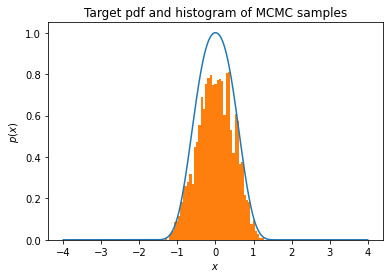

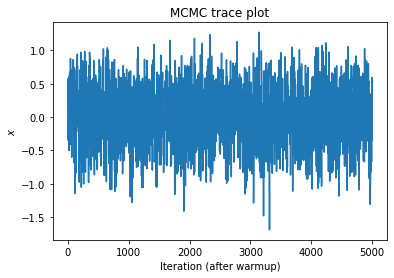

In [3]:
def ex1PDF(theta):
    return np.cos(theta)**2 * np.exp(-np.abs(theta)**3)

def make_plots(theta,thin=1):
    """Make diagnostics plots for MCMC."""
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, ex1PDF(x))
    plt.hist(theta[::thin], bins=50, density=True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$p(x)$')
    plt.title(r'Target pdf and histogram of MCMC samples')
    plt.show()

    plt.plot(theta[::thin])
    plt.xlabel(r'Iteration (after warmup)')
    plt.ylabel(r'$x$')
    plt.title(r'MCMC trace plot')
    plt.show()   

make_plots(theta)

## 2. Sampling a 2D distribution (4 points)

Write a Metropolis-Hastings sampler to evaluate the following expectations over the given (unnormalised) distributions using a suitably scaled multivariate normal distribution with diagonal covariance as the proposal.

1. $E[\theta_1^2 + \theta_2^2]$, when $P^*(\boldsymbol{\theta}) = \exp\left(-3(\sqrt{(\theta_1-\mu_1)^2 + (\theta_2-\mu_2)^2} - r^2)^2 \right)$.
2. $E[\theta_1^2 + \theta_2^2]$, when $P^*(\boldsymbol{\theta}) = \exp\left(-3(\sqrt{(\theta_1-\mu_1)^2 + (\theta_2-\mu_2)^2} - r^2)^2 + |2\theta_1 - \theta_2|\right)$.

Here $\mu_1 = 1, \mu_2 = 2$ and $r = \sqrt{2}$.

The required tolerance for the answer is $\pm 0.3$.

*Hint*: It is useful to check your result by plotting a scatter plot of your samples and a contour plot of the logarithm of the target function. Remember to throw out the warm-up samples!

## 3. MCMC sampling for the posterior of the mean of the Student-t distribution (6 points)

In this exercise we will use MCMC to sample the posterior distribution over the location (or mean) parameter $\mu$ of [Student's $t$-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for a set of data points $X = (x_i)_{i=1}^n$ that are assumed to be conditionally independent given $\mu$, i.e.
$$ p(X | \mu) = \prod_{i=1}^n p(x_i | \mu), $$
where $p(x_i | \mu)$ is the Student's $t$-distribution centred at $\mu$ with $\nu = 5$ degrees of freedom.

Using the data loaded in the below code as $X$,
write a Metropolis-Hastings sampler to draw samples from $p(\mu | X)$ when the prior $p(\mu)$ is as follows, and return the required posterior statistics to Moodle.

1. $p(\mu) = \mathcal{N}(\mu;\; 0, 1^2)$. Report the posterior mean and standard deviation of $\mu$, i.e. mean and standard deviation of $p(\mu | X)$ estimated from the Monte Carlo samples to Moodle.
2. $p(\mu) = \mathrm{Uniform}(\mu;\; -5, 5)$. Report the posterior mean and standard deviation of $\mu$, i.e. mean and standard deviation of $p(\mu | X)$ estimated from the Monte Carlo samples to Moodle.

The require tolerance is $\pm 0.03$.

*Hints*: 
- Please see Chapter 7 of the course notes for more background. 
- You can evaluate the log-pdf of the Student's $t$-distribution using `scipy.stats.t.logpdf()`.
- You can compute posterior mean and standard deviation directly as the mean and standard deviation of your samples. 
- A suitably scaled normal distribution centred at the current point should be a good proposal.
- Remember to throw out the warm-up samples!

In [4]:
import numpy as np
import numpy.random as npr
import pandas as pd

data = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/toydata2.txt', sep='\t', header=None)
data = data.values
data = np.array(data[:,0])


## 4. MCMC sampling for the posterior of gamma distribution parameters (6 points)

In this exercise we test Bayesian estimation of the parameters $\alpha, \beta$ of the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) for a given data set. We will use the shape/rate parametrisation of the gamma distribution. Under this parametrisation, the probability density function of the gamma distribution is
$$ p(x) = \mathrm{Gamma}(x;\; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} \exp(-\beta x), \quad \alpha,\beta > 0,$$
where $\Gamma(x)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

The prior distributions of the parameters $\alpha$ and $\beta$ are
$$ p(\alpha) = \mathrm{Gamma}\left(\frac{1}{2}, \frac{1}{2}\right), \quad p(\beta) = \mathrm{Gamma}\left(\frac{1}{2}, \frac{1}{2}\right), $$
and we assume a factorized prior, i.e. $$p(\alpha, \beta) = p(\alpha) p(\beta).$$

Please remember that the Gamma distribution has the additional constraint that its parameters $\alpha$ and $\beta$ need to be positive. This can be accomplised by parametrising using new unconstrained variables $a,b$ with $\alpha = \exp(a)$ and $\beta = \exp(b)$.

1. Load the data set $\mathcal{D} = \{ x_i | i = 1, \dots, n \}$ using the function below.
2. Implement the log-probability density function of the gamma distribution. Report the value of the log-probability density $\ln p(\alpha)$ at $\alpha = 1$.
3. Transform the prior probability densities of $\alpha$ and $\beta$ to distributions over unbounded variables $a, b$. Report the log-density value $\ln p(a)$ evaluated at $a=1$ in Moodle. (*Hint*: See Sec. 7.3.3. in the course notes!)
4. Sample from the posterior $$p(a, b | \mathcal{D}) \propto p(\mathcal{D}| a, b) p(a) p(b) = \left[\prod_{i=1}^n \text{Gamma}(x_i; \exp(a), \exp(b))\right] p(a) p(b)$$ using a Metropolis-Hastings sampler. *Note*: The symbol $\propto$ means "proportional to", since we omitted the normalization constant $p(\mathcal{D})$ in the denominator of Bayes' theorem. We can do this since Metropolis-Hastings (as most MCMC samplers) does not need the target density to be normalized.
5. Transform the values of $a,b$ back to $\alpha, \beta$ and report the posterior means and standard deviations (`np.mean(alpha_samples)`, `np.std(alpha_samples)`, `np.mean(beta_samples)`, `np.std(beta_samples)`) for $\alpha$ and $\beta$ in Moodle.

The required tolerance for the posterior statistics is $\pm 0.1$.

*Hints*: 
- You can check your implementations of the probability density functions by making sure they are properly normalised using e.g. `scipy.integrate.quad()`. 
- A multivariate normal distribution centred at the current point should be a good proposal. Remember to throw out the warm-up samples!
- As a help, we already provide an implementation of the log pdf of the gamma distribution.

In [5]:
import numpy as np
import pandas as pd
import scipy.special as scs

# 1 load dataset

data1 = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/toydata.txt', sep='\t', header=None)
data1 = data1.values
data1 = np.array(data1[:,0])

# 2

def gamma_logpdf(x, alpha, beta):
    """Log pdf of the gamma distribution with shape/rate parameters alpha and beta."""
    return (alpha*np.log(beta) - scs.gammaln(alpha) + (alpha-1) * np.log(x) - beta * x)